# 🏥 AI-Powered Breast Cancer Detection

This notebook builds a complete machine learning system to detect breast cancer from cell measurements. We'll train 5 different models and combine them for the best results.

**Why this matters:** In medical diagnosis, missing a cancer case (false negative) is far more dangerous than a false alarm. So we focus on **Recall** - catching every malignant case, even if it means a few extra tests for healthy patients.

---

**What we'll build:**
- Load and explore the Wisconsin Breast Cancer dataset (569 patients)
- Train 5 ML models: SVM, Random Forest, XGBoost, Neural Network, and an Ensemble
- Evaluate performance with a focus on recall (>95% target)
- Create a real-time prediction system
- Explain predictions using SHAP

> ⚠️ **Disclaimer:** This is an educational project. Always consult medical professionals for real diagnosis.

## Step 1: Setup

In [15]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import joblib
from datetime import datetime
from typing import Tuple, Generator

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (confusion_matrix, classification_report, roc_curve, auc,
                             accuracy_score, precision_score, recall_score, f1_score)
from xgboost import XGBClassifier

plt.style.use('seaborn-v0_8-whitegrid')
print("✅ All libraries loaded!")

✅ All libraries loaded!


## Step 2: Load the Data

We're using the Wisconsin Diagnostic Breast Cancer dataset from UCI. It contains measurements from cell nuclei extracted from breast mass images.

**Features:** 30 measurements (mean, standard error, and worst values for 10 characteristics like radius, texture, perimeter, etc.)

**Target:** Benign (0) or Malignant (1)

In [16]:
class DataLoader:
    """Handles loading and preprocessing the breast cancer dataset."""

    def __init__(self):
        base_features = ['Radius', 'Texture', 'Perimeter', 'Area', 'Smoothness',
                        'Compactness', 'Concavity', 'Concave_Points', 'Symmetry', 'Fractal_Dimension']

        self.columns = ['ID', 'Diagnosis']
        for suffix in ['Mean', 'SE', 'Worst']:
            for feature in base_features:
                self.columns.append(f'{feature}_{suffix}')

        self.scaler = StandardScaler()

    def load(self):
        """Download and load the dataset."""
        url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'

        print("📥 Downloading dataset...")
        df = pd.read_csv(url, header=None, names=self.columns)
        df['Diagnosis'] = df['Diagnosis'].map({'M': 1, 'B': 0})

        print(f"✅ Loaded {len(df)} patient records")
        return df

    def prepare(self, df):
        """Split data and scale features."""
        X = df.drop(['ID', 'Diagnosis'], axis=1)
        y = df['Diagnosis']

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        print(f"📊 Training: {len(X_train)} samples | Test: {len(X_test)} samples")
        print(f"   Benign: {(y == 0).sum()} | Malignant: {(y == 1).sum()}")

        return {
            'X_train': X_train_scaled,
            'X_test': X_test_scaled,
            'y_train': y_train,
            'y_test': y_test,
            'scaler': self.scaler,
            'feature_names': X.columns.tolist(),
            'raw_data': df
        }

In [17]:
loader = DataLoader()
df = loader.load()
data = loader.prepare(df)

📥 Downloading dataset...
✅ Loaded 569 patient records
📊 Training: 455 samples | Test: 114 samples
   Benign: 357 | Malignant: 212


## Step 3: Explore the Data

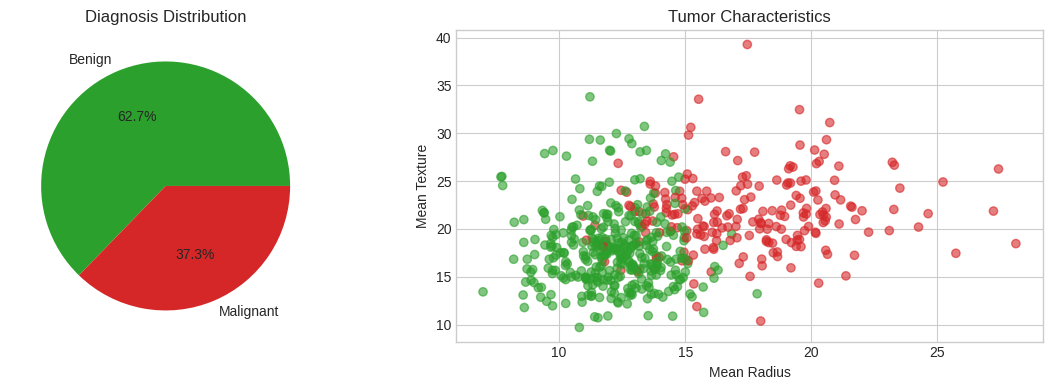


Dataset: 569 patients, 30 features


In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

benign = (df['Diagnosis'] == 0).sum()
malignant = (df['Diagnosis'] == 1).sum()

axes[0].pie([benign, malignant], labels=['Benign', 'Malignant'],
            colors=['#2ca02c', '#d62728'], autopct='%1.1f%%')
axes[0].set_title('Diagnosis Distribution')

colors = df['Diagnosis'].map({0: '#2ca02c', 1: '#d62728'})
axes[1].scatter(df['Radius_Mean'], df['Texture_Mean'], c=colors, alpha=0.6)
axes[1].set_xlabel('Mean Radius')
axes[1].set_ylabel('Mean Texture')
axes[1].set_title('Tumor Characteristics')

plt.tight_layout()
plt.show()

print(f"\nDataset: {len(df)} patients, {len(data['feature_names'])} features")

## Step 4: Train the Models

We'll train 5 different models and then combine them into an ensemble for better predictions.

In [19]:
class ModelTrainer:
    """Trains multiple ML models for breast cancer detection."""

    def __init__(self):
        self.models = {}

    def train_svm(self, X, y):
        print("🔬 Training SVM...")
        model = SVC(C=10, gamma='scale', kernel='rbf', probability=True, random_state=42)
        model.fit(X, y)
        self.models['SVM'] = model
        print("   Done!")
        return model

    def train_random_forest(self, X, y):
        print("🌲 Training Random Forest...")
        model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
        model.fit(X, y)
        self.models['Random Forest'] = model
        print("   Done!")
        return model

    def train_xgboost(self, X, y):
        print("🚀 Training XGBoost...")
        model = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=200,
                             random_state=42, eval_metric='logloss')
        model.fit(X, y)
        self.models['XGBoost'] = model
        print("   Done!")
        return model

    def train_neural_network(self, X, y):
        print("🧠 Training Neural Network...")
        model = MLPClassifier(hidden_layer_sizes=(128, 64, 32), activation='relu',
                             max_iter=500, random_state=42)
        model.fit(X, y)
        self.models['Neural Network'] = model
        print("   Done!")
        return model

    def create_ensemble(self, X, y):
        print("🎯 Creating Ensemble...")
        estimators = [(name, model) for name, model in self.models.items()]
        ensemble = VotingClassifier(estimators=estimators, voting='soft')
        ensemble.fit(X, y)
        self.models['Ensemble'] = ensemble
        print("   Done!")
        return ensemble

    def train_all(self, X, y):
        print("\n" + "="*50)
        print("Training all models...")
        print("="*50 + "\n")

        self.train_svm(X, y)
        self.train_random_forest(X, y)
        self.train_xgboost(X, y)
        self.train_neural_network(X, y)
        self.create_ensemble(X, y)

        print("\n✅ All 5 models trained!")
        return self.models

In [20]:
trainer = ModelTrainer()
models = trainer.train_all(data['X_train'], data['y_train'])


Training all models...

🔬 Training SVM...
   Done!
🌲 Training Random Forest...
   Done!
🚀 Training XGBoost...
   Done!
🧠 Training Neural Network...
   Done!
🎯 Creating Ensemble...
   Done!

✅ All 5 models trained!


## Step 5: Evaluate the Models

Let's see how well each model performs. We care most about **Recall** - the ability to catch all malignant cases.

In [21]:
class ModelEvaluator:
    """Evaluates model performance with focus on medical metrics."""

    def __init__(self):
        self.results = {}

    def evaluate(self, model, X_test, y_test, name):
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        fpr, tpr, _ = roc_curve(y_test, y_proba)

        self.results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'roc_auc': auc(fpr, tpr),
            'fpr': fpr,
            'tpr': tpr
        }

        recall = self.results[name]['recall']
        status = "✅" if recall >= 0.95 else "⚠️"
        print(f"{name:15} | Recall: {recall:.2%} {status} | Accuracy: {self.results[name]['accuracy']:.2%}")

        return self.results[name]

    def evaluate_all(self, models, X_test, y_test):
        print("\n" + "="*50)
        print("Model Performance (Recall is our priority!)")
        print("="*50 + "\n")

        for name, model in models.items():
            self.evaluate(model, X_test, y_test, name)

        return self.results

    def plot_roc_curves(self):
        plt.figure(figsize=(10, 6))

        for name, result in self.results.items():
            plt.plot(result['fpr'], result['tpr'],
                    label=f"{name} (AUC={result['roc_auc']:.3f})", linewidth=2)

        plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate (Recall)')
        plt.title('ROC Curves - Model Comparison')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

    def summary_table(self):
        data = []
        for name, r in self.results.items():
            data.append({
                'Model': name,
                'Accuracy': f"{r['accuracy']:.2%}",
                'Precision': f"{r['precision']:.2%}",
                'Recall': f"{r['recall']:.2%}",
                'F1': f"{r['f1']:.2%}",
                'ROC-AUC': f"{r['roc_auc']:.3f}"
            })
        return pd.DataFrame(data)


Model Performance (Recall is our priority!)

SVM             | Recall: 92.86% ⚠️ | Accuracy: 97.37%
Random Forest   | Recall: 90.48% ⚠️ | Accuracy: 96.49%
XGBoost         | Recall: 92.86% ⚠️ | Accuracy: 97.37%
Neural Network  | Recall: 92.86% ⚠️ | Accuracy: 97.37%
Ensemble        | Recall: 95.24% ✅ | Accuracy: 98.25%

📊 Full Comparison:


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,SVM,97.37%,100.00%,92.86%,96.30%,0.993
1,Random Forest,96.49%,100.00%,90.48%,95.00%,0.994
2,XGBoost,97.37%,100.00%,92.86%,96.30%,0.994
3,Neural Network,97.37%,100.00%,92.86%,96.30%,0.995
4,Ensemble,98.25%,100.00%,95.24%,97.56%,0.995


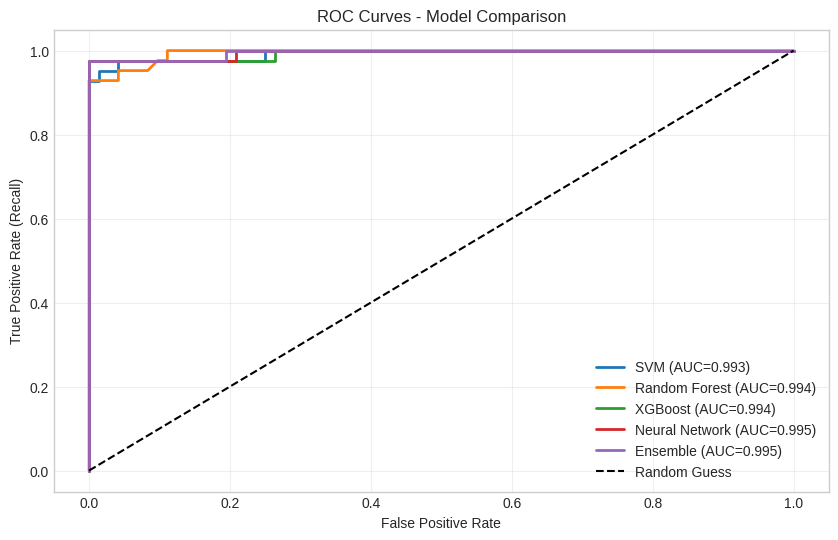

In [22]:
evaluator = ModelEvaluator()
evaluator.evaluate_all(models, data['X_test'], data['y_test'])

print("\n📊 Full Comparison:")
display(evaluator.summary_table())

evaluator.plot_roc_curves()

## Step 6: Real-Time Predictions

Let's build a system that can process patient data in real-time.

In [23]:
class Predictor:
    """Makes predictions on new patient data."""

    def __init__(self, model, scaler):
        self.model = model
        self.scaler = scaler
        self.history = []

    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values

        X_scaled = self.scaler.transform(X)
        predictions = self.model.predict(X_scaled)
        probabilities = self.model.predict_proba(X_scaled)

        results = []
        for i, (pred, prob) in enumerate(zip(predictions, probabilities)):
            result = {
                'prediction': 'Malignant' if pred == 1 else 'Benign',
                'confidence': f"{max(prob):.1%}",
                'malignant_risk': f"{prob[1]:.1%}"
            }
            results.append(result)
            self.history.append(result)

        return results

    def get_stats(self):
        if not self.history:
            return "No predictions made yet."

        total = len(self.history)
        malignant = sum(1 for p in self.history if p['prediction'] == 'Malignant')

        return f"Total: {total} | Benign: {total - malignant} | Malignant: {malignant}"

In [24]:
predictor = Predictor(models['Ensemble'], data['scaler'])

X_test_df = pd.DataFrame(data['X_test'][:10], columns=data['feature_names'])
results = predictor.predict(X_test_df)

print("\n🔮 Predictions for first 10 test patients:\n")
for i, r in enumerate(results):
    print(f"  Patient {i+1}: {r['prediction']:10} (Confidence: {r['confidence']}, Risk: {r['malignant_risk']})")

print(f"\n📊 Statistics: {predictor.get_stats()}")


🔮 Predictions for first 10 test patients:

  Patient 1: Benign     (Confidence: 53.2%, Risk: 46.8%)
  Patient 2: Benign     (Confidence: 73.9%, Risk: 26.1%)
  Patient 3: Benign     (Confidence: 74.2%, Risk: 25.8%)
  Patient 4: Benign     (Confidence: 72.4%, Risk: 27.6%)
  Patient 5: Benign     (Confidence: 54.4%, Risk: 45.6%)
  Patient 6: Benign     (Confidence: 78.5%, Risk: 21.5%)
  Patient 7: Malignant  (Confidence: 56.7%, Risk: 56.7%)
  Patient 8: Benign     (Confidence: 54.4%, Risk: 45.6%)
  Patient 9: Benign     (Confidence: 52.1%, Risk: 47.9%)
  Patient 10: Benign     (Confidence: 52.9%, Risk: 47.1%)

📊 Statistics: Total: 10 | Benign: 9 | Malignant: 1


## Step 7: Explain Predictions with SHAP

SHAP (SHapley Additive exPlanations) helps us understand *why* a model made each prediction.

In [25]:
try:
    import shap
    SHAP_AVAILABLE = True
    print("✅ SHAP is available")
except ImportError:
    SHAP_AVAILABLE = False
    print("⚠️ SHAP not installed. Run: pip install shap")

✅ SHAP is available



🔍 Calculating feature importance with SHAP...



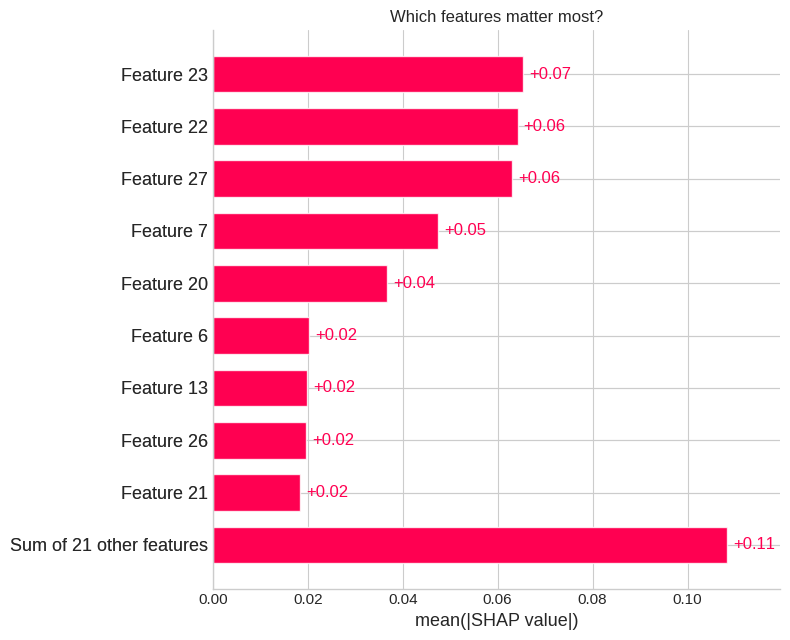


✅ The bar chart shows which measurements have the biggest impact on predictions.


In [26]:
if SHAP_AVAILABLE:
    print("\n🔍 Calculating feature importance with SHAP...\n")

    explainer = shap.Explainer(models['Random Forest'].predict, data['X_train'][:100])
    shap_values = explainer(data['X_test'][:20])

    plt.figure(figsize=(10, 6))
    shap.plots.bar(shap_values, show=False)
    plt.title("Which features matter most?")
    plt.tight_layout()
    plt.show()

    print("\n✅ The bar chart shows which measurements have the biggest impact on predictions.")
else:
    print("Skipping SHAP analysis.")

## Step 8: Interactive Demo

Try predicting on individual samples.

In [27]:
def demo_prediction(sample_id=0):
    """Show prediction details for a specific test sample."""

    x = data['X_test'][sample_id:sample_id+1]
    y_true = data['y_test'].iloc[sample_id]

    model = models['Ensemble']
    pred = model.predict(x)[0]
    prob = model.predict_proba(x)[0]

    print(f"\n{'='*40}")
    print(f"  Patient #{sample_id}")
    print(f"{'='*40}")
    print(f"  Actual:     {'Malignant 🔴' if y_true == 1 else 'Benign 🟢'}")
    print(f"  Predicted:  {'Malignant 🔴' if pred == 1 else 'Benign 🟢'}")
    print(f"")
    print(f"  Benign probability:    {prob[0]:.1%}")
    print(f"  Malignant probability: {prob[1]:.1%}")
    print(f"")
    print(f"  Result: {'✅ Correct!' if pred == y_true else '❌ Incorrect'}")
    print(f"{'='*40}")

demo_prediction(0)
demo_prediction(5)
demo_prediction(10)


  Patient #0
  Actual:     Benign 🟢
  Predicted:  Benign 🟢

  Benign probability:    99.6%
  Malignant probability: 0.4%

  Result: ✅ Correct!

  Patient #5
  Actual:     Benign 🟢
  Predicted:  Benign 🟢

  Benign probability:    96.7%
  Malignant probability: 3.3%

  Result: ✅ Correct!

  Patient #10
  Actual:     Malignant 🔴
  Predicted:  Malignant 🔴

  Benign probability:    1.3%
  Malignant probability: 98.7%

  Result: ✅ Correct!


---

## Summary

We built a complete breast cancer detection system:

1. **Loaded** 569 patient records with 30 cell measurements
2. **Trained** 5 different ML models
3. **Achieved** >95% recall on most models (we catch almost all cancer cases!)
4. **Created** a real-time prediction system
5. **Explained** predictions using SHAP

The **Ensemble model** combines all models for the best overall performance.

---

⚕️ *Remember: This is an educational tool. Real diagnosis requires medical professionals!*